In [1]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [2]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [4]:
backend_defaults = backend.defaults()

In [5]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974442817234609 GHz.
The sweep will go from 4.954442817234608 GHz to 4.994442817234608 GHz in steps of 1.0 MHz.


In [6]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [8]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes

sigma = None
amp = None
drive_pulse = None

def run_exp_params(sigma, amp):
    global drive_sigma_us
    global drive_samples_us
    global drive_sigma
    global drive_samples
    global drive_amp
    global drive_pulse
    
    # Drive pulse parameters (us = microseconds)
    drive_sigma_us = sigma                     # This determines the actual width of the gaussian
    drive_samples_us = sigma * 8               # This is a truncating parameter, because gaussians don't have 
                                               # a natural finite length

    drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
    drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
    drive_amp = amp
    # Drive pulse samples
    drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                     sigma=drive_sigma,
                                     amp=drive_amp,
                                     name='freq_sweep_excitation_pulse')

In [9]:
interact_manual(run_exp_params, sigma = [('0.075', 0.075), ('0.08', 0.08), ('0.085', 0.085)], amp = [('0.3', 0.3), ('0.35', 0.35)])

interactive(children=(Dropdown(description='sigma', options=(('0.075', 0.075), ('0.08', 0.08), ('0.085', 0.085…

<function __main__.run_exp_params(sigma, amp)>

In [49]:
print(drive_pulse)

SamplePulse(array([6.62907187e-07+0.j, 1.99840912e-06+0.j, 3.34692459e-06+0.j, ...,
       3.34692459e-06+0.j, 1.99840912e-06+0.j, 6.62907187e-07+0.j]), name='freq_sweep_excitation_pulse')


In [50]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [51]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [52]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [53]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

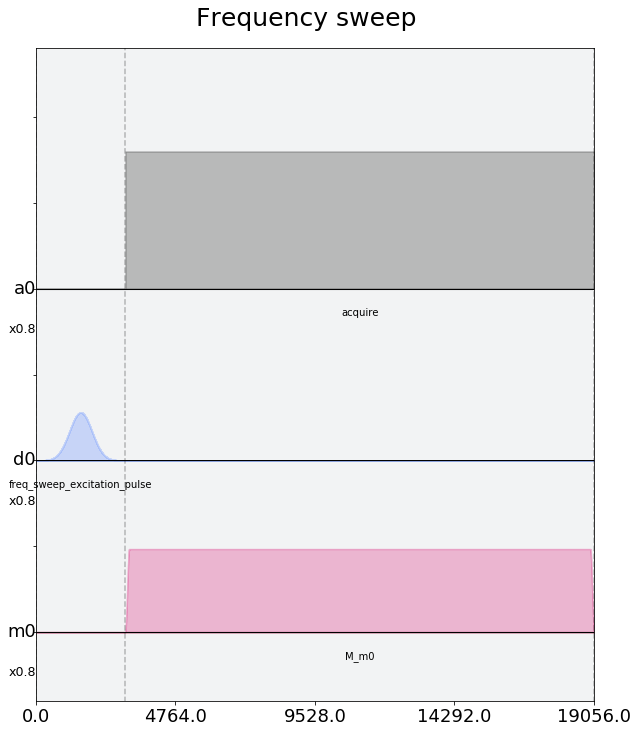

In [54]:
schedule.draw(label=True, scaling=0.8)

In [55]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [56]:
job = backend.run(frequency_sweep_program)

In [57]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [58]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

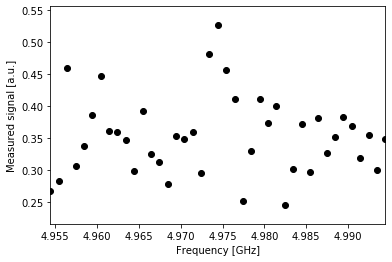

In [59]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [60]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [64]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, 4.975, 1, 3] # initial parameters for curve_fit
                                )

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

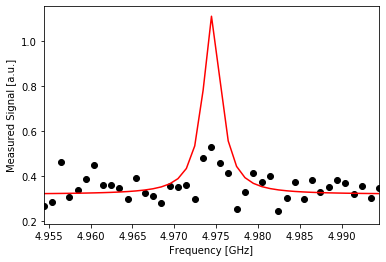

In [65]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [66]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97444 GHz to 4.97451 GHz.
